# <span style="color:blue"> Laboratorio di simulazione numerica (LSN) </span>

## <span style="color:green">  Esercitazione numerica 8</span>

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

### Esercizio 8.2

Il primo obiettivo dell'esercitazione consiste nella scrittura di un codice in grado di risolvere un problema non risolvibile analiticamente: ricercare con approccio variazionale il ground state di una particella quantistica nello spazio monodimensionale sottoposta all'azione di un potenziale:
$$V(x)= x^4- \frac{5}{2}x^2$$

Per farlo ho scritto un codice Variational Monte Carlo per campionare la funzione d'onda di prova:
$$
\Psi_T^{\sigma,\mu}(x) \propto e^{-\frac{(x-\mu)^2}{2\sigma^2}}+
                               e^{-\frac{(x+\mu)^2}{2\sigma^2}}
$$

L'biettivo è trovare i parametri $\sigma$ e $\mu$ che minimizzano il valore di aspettazione dell'hamiltoniana $\langle {\hat H} \rangle_T$:

$$
\langle {\hat H} \rangle_T = \frac{\langle \Psi_T^{\sigma,\mu}| {\hat H} | \Psi_T^{\sigma,\mu} \rangle}
{\langle \Psi_T^{\sigma,\mu} | \Psi_T^{\sigma,\mu} \rangle} \ge E_0 =
\frac{\langle \Psi_0| {\hat H} | \Psi_0 \rangle}
{\langle \Psi_0 | \Psi_0 \rangle}
$$

Per fare ciò ho realizzato una routine di **Simulated Annealing** chiamata `OptimizedParameters()` composta da due cicli innestati:

- un ciclo esterno su certo intervallo di temperature fittizie $T$;
- un ciclo interno su un determinato numero di step in cui campiono nuovi valori per $\mu$ e $\sigma$.

Per ogni step del ciclo interno calcolo dunque il valor medio dell'hamiltoniana coi valori attuali di $\mu$ e $\sigma$, dopodichè compio uno step uniforme per generare nuovi valori per i due parametri e calcolo il valor medio dell'hamiltoniana. Il nuovi parametri vengono dunque accettati con probabilità:
$$p= \text{exp}(-\frac{1}{T}[<\hat{H}(\mu_{new};\sigma_{new})>-<\hat{H}(\mu;\sigma)>])$$

Finita la procedura seleziono $\sigma$ e $\mu$ per cui il valor medio dell'hamiltoniana è minore. 

Per convergere al valore desiderato è bene non partire da una temperatura troppo elevata (io ho scelto $T=0.1$). 
Di seguito mostro tutti i valori campionati durante la procedura ed i valori finali ottenuti.

/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  after removing the cwd from sys.path.


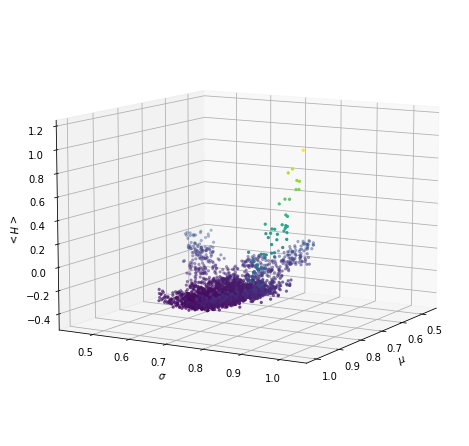

<H> minimized for mu = 0.791754 , sigma = 0.637379


In [17]:
mu, sigma, H = np.loadtxt("../results/sampled_mu_sigma.dat", usecols=(0,1,2), unpack = True)

fig = plt.figure(figsize = (12, 6))
ax = Axes3D(fig)
ax.scatter(mu, sigma, H, c=H, marker='.')
ax.set_xlabel('$\mu$')
ax.set_ylabel('$\sigma$')
ax.set_zlabel('$<H>$')
ax.view_init(10, 30)

plt.show()

print("<H> minimizzata da mu =", mu[np.argsort(H)[0]], ", sigma =", sigma[np.argsort(H)[0]])

Coi valori ottenuti ho dunque prodotto un grafico con la stima di $\Psi_T^{\sigma,\mu}(x) \propto e^{-\frac{(x-\mu)^2}{2\sigma^2}}+e^{-\frac{(x+\mu)^2}{2\sigma^2}}$
e relativa incertezza statistica in funzione del numero di blocchi.
Ho inoltre graficato l'istogramma con le configurazioni campionate per ottenere la funzione d'onda campionata $|\Psi_T(x)|^2$, e l'ho confronata con la soluzione analitica e la soluzione numerica ottenuta trasformando l'equazione di Schrodinger in forma matriciale come indicato nel jupyter.

In [18]:
def Vpot(x):
    return (x**2 - 2.5)*x**2
    #return 0.5*x**2
    
def PDF(x, mu, sigma):
    wf=np.exp(-(x-mu)**2/(2.*sigma**2))+np.exp(-(x+mu)**2/(2.*sigma**2))
    return wf*wf

hbar = 1
m = 1
a = 6
N = 1000 # number of iterations

# Step sizes
x = np.linspace(-a/2, a/2, N)
dx = x[1] - x[0] # the step size
V = Vpot(x)

# The central differences method: f" = (f_1 - 2*f_0 + f_-1)/dx^2

CDiff = np.diag(np.ones(N-1),-1)-2*np.diag(np.ones(N),0)+np.diag(np.ones(N-1),1)
# np.diag(np.array,k) construct a "diagonal" matrix using the np.array
# The default is k=0. Use k>0 for diagonals above the main diagonal, 
# and k<0 for diagonals below the main diagonal

# Hamiltonian matrix
H = (-(hbar**2)*CDiff)/(2*m*dx**2) + np.diag(V)

# Compute eigenvectors and their eigenvalues
E,psi = np.linalg.eigh(H)

# Take the transpose & normalize
psi = np.transpose(psi)
psi = psi/np.sqrt(dx)

print("Ground state energy: ", E[0])

Ground state energy:  -0.46045845079911685


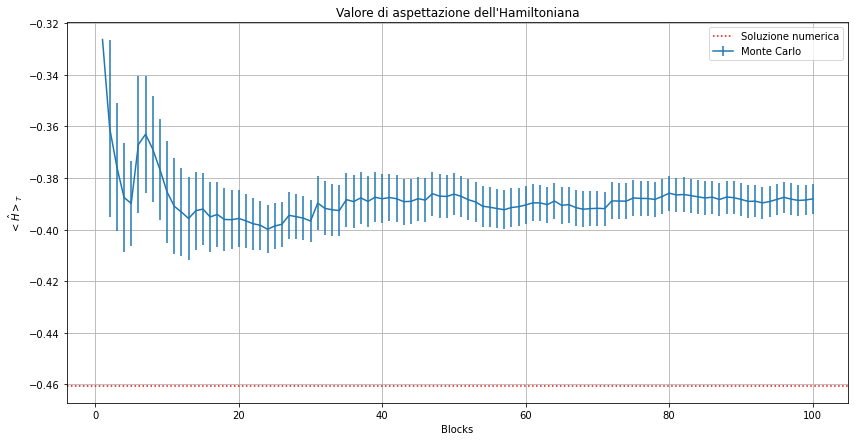

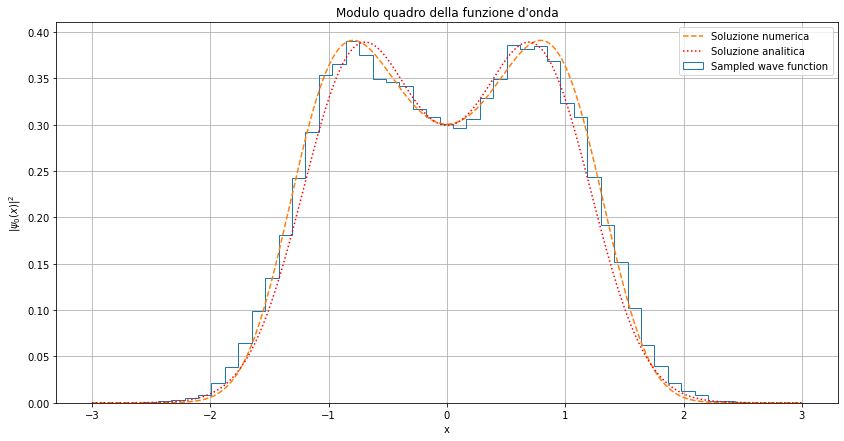

In [19]:
plt.figure(1, figsize = (14, 7))
x_H, y_H, yerr_H = np.loadtxt("../results/h_ave.dat", unpack = True)

plt.title("Valore di aspettazione dell'Hamiltoniana")
plt.xlabel('Blocks')
plt.ylabel('$< \hat H >_T$')
plt.axhline(y=E[0], color='r', linestyle="dotted", label = "Soluzione numerica")
plt.errorbar(x_H, y_H, yerr_H, label = "Monte Carlo")
plt.grid(True)
plt.legend()

plt.figure(2, figsize = (14, 7))
x_pos = np.loadtxt("../results/x_pos.dat")

scale = 0.35
nbins = 50
data, data_bin, boh = plt.hist(x_pos, nbins, density=True, histtype='step', label="Sampled wave function")
plt.plot(x,(psi[0])**2, label="Soluzione numerica", linestyle='dashed')
plt.plot(x, scale*PDF(x, 0.791754, 0.637379), label="Soluzione analitica", color='r', linestyle="dotted")
plt.title("Modulo quadro della funzione d'onda")
plt.xlabel("x")
plt.ylabel(r"$|\psi_0(x)|^2$")
plt.grid(True)
plt.legend()

plt.show()


Il valore di aspettazione è superiore a quello calcolato numericamente come ci si aspettava.

### Esercizio 8.3

Per questo esercizio ho utilizzato il codice `PIGS/PIMC` fornito ed opportunamente modificato per studiare lo stesso sistema quantistico 1D descritto sopra. 
I risultati dell'algoritmo `PIGS` ($T=0$) sono stati caalcolati a partire da due diverse funzioni d'onda di prova:

- $\Psi_T(x)=1$ funzione d'onda costante
- $\Psi_T(x)=\Psi^{\sigma,\mu}_T(x)$ con $\sigma$ e $\mu$ trovati precedentemente

Di seguito riporto i risultati ottenuti e li confronto con quelli provenienti dalla mia simulazione Monte Carlo e con la soluzione numerica

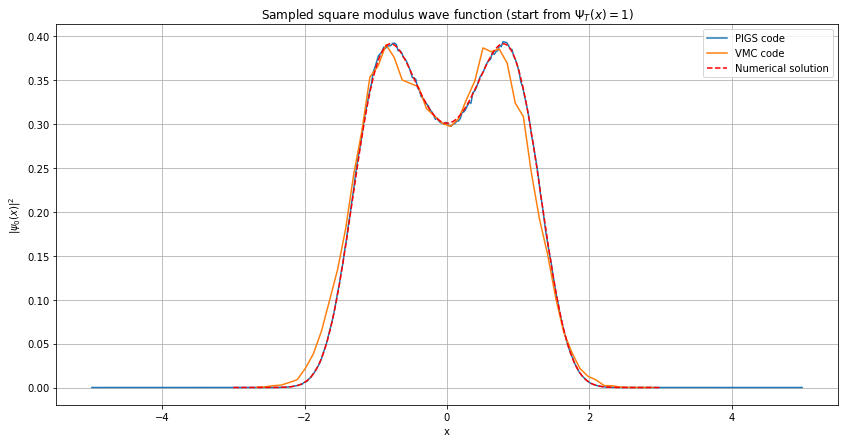

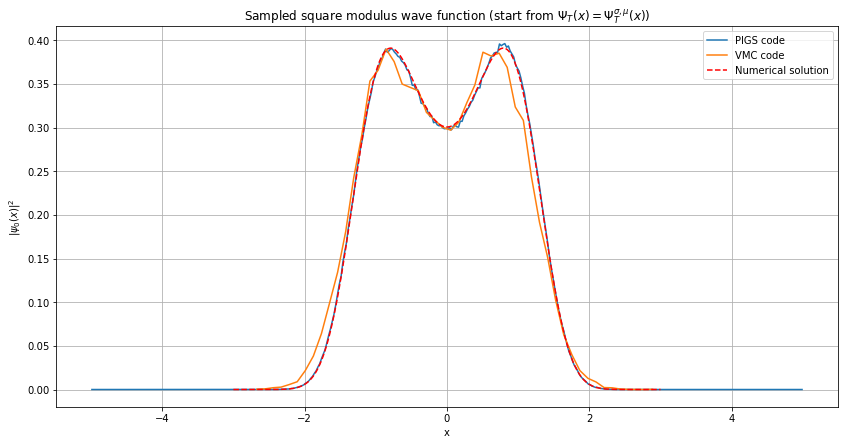

In [16]:

plt.figure(1, figsize=(14,7))
x_pigs_const, y_pigs_const, yerr_pigs_const = np.loadtxt("../results/probability_pigs_uniform.dat", unpack = True)

plt.plot(x_pigs_const, y_pigs_const, label="PIGS code")
plt.plot(data_bin[:-1],data, label="VMC")
plt.plot(x,(psi[0])**2, label="Soluzione numerica", linestyle='dashed', color='r')
plt.title("Modulo quadro funzione d'onda campionata (start from $\Psi_T(x)=1$)")
plt.xlabel("x")
plt.ylabel(r"$|\psi_0(x)|^2$")
plt.grid(True)
plt.legend()

plt.figure(2, figsize=(14,7))
x_pigs_tr, y_pigs_tr, yerr_pigs_tr = np.loadtxt("../results/probability_pigs_exact.dat", unpack = True)

plt.plot(x_pigs_tr, y_pigs_tr, label="PIGS")
plt.plot(data_bin[:-1], data, label="VMC")
plt.plot(x,(psi[0])**2, label="Soluzione numerica", linestyle='dashed', color='r')
plt.title("SModulo quadro funzione d'onda campionata (start from $\Psi_T(x) = \Psi_T^{\sigma,\mu}(x)$)")
plt.xlabel("x")
plt.ylabel(r"$|\psi_0(x)|^2$")
plt.grid(True)
plt.legend()

plt.show()

I risultati ottenuti tramite `PIGS` sono molto più in accordo con la soluzione numerica rispetto ai quelli ottenuti col Variational Monte Carlo.

Per ottenere risultati con funzione d'onda di prova costante $\Psi_T(x)=1$ ho utilizzato un *imaginaryTimePropagation=4.0*; per valori inferiori la soluzione si distacca visibilmente da quella numerica.
Utilizzando la funzione $\Psi^{\sigma,\mu}_T(x)$ è possibile ridurre questo tempo fino a circa *2.0*.
Questo è ovvio poichè $\Psi^{\sigma,\mu}_T(x)$ è molto più vicino al ground state e quindi converge più velocemente.


L'ultimo punto richiedeva di utilizzare l'algoritmo `PIMC` a diverse $T>0$ ed osservare come varia la funzione d'onda:

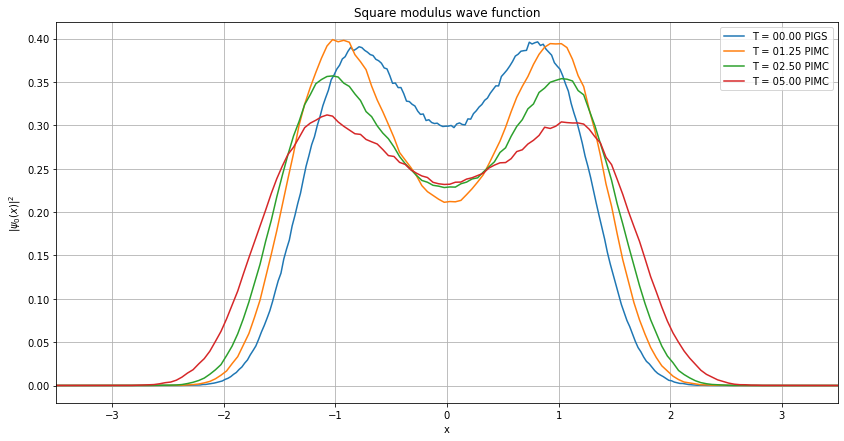

In [15]:

plt.figure(figsize = (14, 7))

x_pimc_1_25, y_pimc_1_25, yerr_pimc_1_25 = np.loadtxt("../results/T_1_25.dat", unpack = True)
x_pimc_2_50, y_pimc_2_50, yerr_pimc_2_50 = np.loadtxt("../results/T_2_5.dat", unpack = True)
x_pimc_5_00, y_pimc_5_00, yerr_pimc_5_00 = np.loadtxt("../results/T_5.dat", unpack = True)


plt.plot(x_pigs_tr, y_pigs_tr, label="T = 00.00 PIGS")
plt.plot(x_pimc_1_25, y_pimc_1_25, label="T = 01.25 PIMC")
plt.plot(x_pimc_2_50, y_pimc_2_50, label="T = 02.50 PIMC")
plt.plot(x_pimc_5_00, y_pimc_5_00, label="T = 05.00 PIMC")

plt.xlim((-3.5, 3.5))
plt.title("Square modulus wave function")
plt.xlabel("x")
plt.ylabel(r"$|\psi_0(x)|^2$")
plt.grid(True)
plt.legend()

plt.show()

Aumentando la temperatura osserviamo chiaramente come il minimo centrale si alzi e le code delle funzioni d'onda diventino più ampie. Questo è naturale poichè all'umentare della temperatura gli stati eccitati iniziano ad avere un maggior contributo e la nostra funzione d'onda è data dalla loro sovrapposizione.